#Firstly we will build a spark session as we are making our project using pyspark

#About the Dataset
This dataset represents monthly air quality readings for the city of Nagpur, India, collected through environmental and AQM sensors deployed at various city locations. The data helps in assessing the air quality situation, tracking pollution trends, and identifying potentially polluting areas.

In [1]:
from pyspark.sql import SparkSession

# Start a Spark session
spark = SparkSession.builder.appName("NagpurPollutionLoad").getOrCreate()
df = spark.read.csv("Nagpur.csv", header=True, inferSchema=True)
df.show()

+---------+----------+----------+----------+--------+--------+-------+------------------------------------------------+---------------+
|City Name|Month-Year|PM25(ug/m)|PM10(ug/m)|NO2(PPM)|SO2(PPM)|O3(PPM)|No of AQM Sensors/Environmental sensors deployed|Polluter or Not|
+---------+----------+----------+----------+--------+--------+-------+------------------------------------------------+---------------+
|   Nagpur|    18-Dec|     62.93|     69.61|   0.037|   0.012|  0.041|                               Automotive Square|       Polluter|
|   Nagpur|    18-Nov|      55.5|     62.81|   0.023|   0.015|  0.037|                               Automotive Square|   Not Polluter|
|   Nagpur|    18-Oct|     32.47|     36.53|   0.018|   0.021|  0.036|                               Automotive Square|   Not Polluter|
|   Nagpur|    18-Sep|     25.76|     28.82|   0.016|    0.03|  0.029|                               Automotive Square|   Not Polluter|
|   Nagpur|    18-Aug|      16.9|     18.76|   0

In [2]:
# Print the schema to verify data types
df.printSchema()

root
 |-- City Name: string (nullable = true)
 |-- Month-Year: string (nullable = true)
 |-- PM25(ug/m): double (nullable = true)
 |-- PM10(ug/m): double (nullable = true)
 |-- NO2(PPM): double (nullable = true)
 |-- SO2(PPM): double (nullable = true)
 |-- O3(PPM): double (nullable = true)
 |-- No of AQM Sensors/Environmental sensors deployed: string (nullable = true)
 |-- Polluter or Not: string (nullable = true)



In [3]:
from pyspark.sql.functions import col, avg, max, min, count, stddev

In [4]:
df.describe([
    'PM25(ug/m)',
    'PM10(ug/m)',
    'NO2(PPM)',
    'SO2(PPM)',
    'O3(PPM)',
    'Polluter or Not'
]).show()

+-------+------------------+------------------+-------------------+-------------------+-------------------+---------------+
|summary|        PM25(ug/m)|        PM10(ug/m)|           NO2(PPM)|           SO2(PPM)|            O3(PPM)|Polluter or Not|
+-------+------------------+------------------+-------------------+-------------------+-------------------+---------------+
|  count|                81|                81|                 81|                 81|                 81|            240|
|   mean|55.612716049382726| 66.14345679012344|0.10665432098765433|0.11158024691358025|0.07897530864197529|           NULL|
| stddev| 32.86908855643649|35.964780173125405| 0.3867375130658334| 0.2144987683063431|0.22835525915274218|           NULL|
|    min|             10.73|             14.16|              0.004|              0.012|              0.008|   Not Polluter|
|    max|            193.35|            200.26|              3.518|               1.82|              2.065|       Polluter|
+-------

In [5]:
pollution_count = df.groupBy("Polluter or Not").count()
pollution_count.show()


+---------------+-----+
|Polluter or Not|count|
+---------------+-----+
|   Not Polluter|  179|
|       Polluter|   61|
+---------------+-----+



In [6]:
# Average Pollution by Month (Month-Year)
monthly_pollution = df.groupBy("Month-Year").agg(
    avg("PM25(ug/m)").alias("Avg_PM2.5"),
    avg("PM10(ug/m)").alias("Avg_PM10"),
    avg("NO2(PPM)").alias("Avg_NO2"),
    avg("SO2(PPM)").alias("Avg_SO2"),
    avg("O3(PPM)").alias("Avg_O3")
)
monthly_pollution.show()


+----------+------------------+------------------+--------------------+-------------------+--------------------+
|Month-Year|         Avg_PM2.5|          Avg_PM10|             Avg_NO2|            Avg_SO2|              Avg_O3|
+----------+------------------+------------------+--------------------+-------------------+--------------------+
|    18-Mar|             83.78|             95.58|               0.107|              0.052|               0.083|
|    17-Jan|              NULL|              NULL|                NULL|               NULL|                NULL|
|    18-Nov| 79.73500000000001|            94.039| 0.06080000000000001|0.08230000000000001|              0.0496|
|      NULL|              NULL|              NULL|                NULL|               NULL|                NULL|
|    18-Apr|55.956999999999994| 65.64500000000001|               0.077|0.11069999999999999| 0.11410000000000001|
|    17-Oct|              NULL|              NULL|                NULL|               NULL|     

In [7]:
#Correlation between pollutants
correlation_pm2_5_pm10 = df.stat.corr("PM25(ug/m)", "PM10(ug/m)")
correlation_pm2_5_no2 = df.stat.corr("PM25(ug/m)", "NO2(PPM)")
correlation_pm2_5_o3 = df.stat.corr("PM25(ug/m)", "O3(PPM)")

print(f"Correlation between PM2.5 and PM10: {correlation_pm2_5_pm10}")
print(f"Correlation between PM2.5 and NO2: {correlation_pm2_5_no2}")
print(f"Correlation between PM2.5 and O3: {correlation_pm2_5_o3}")

Correlation between PM2.5 and PM10: 0.9914478290186044
Correlation between PM2.5 and NO2: 0.3071766251892058
Correlation between PM2.5 and O3: 0.35181976004810467


#**PM 2.5 and PM 10 are heavily correleated**

#Convert dataframe to pandas dataframe to visualize data

In [8]:
# Convert to Pandas DataFrame
pollution_pd = df.toPandas()


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

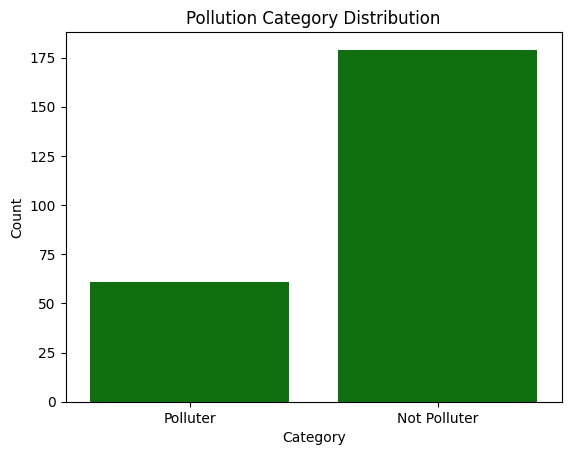

In [10]:
# Count of pollution and no pollution
sns.countplot(x='Polluter or Not', data=pollution_pd,color='green')
plt.title("Pollution Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


# As evident from the graph as PM  2.5 increases so PM 10 increases and vice versa

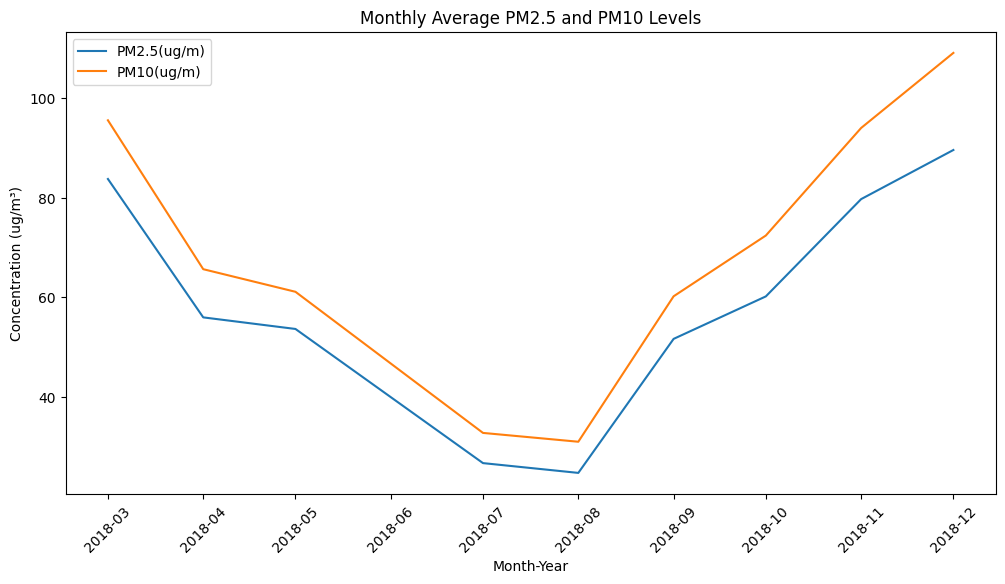

In [11]:
# Convert 'Month-Year' to datetime format for sorting
pollution_pd['Month-Year'] = pd.to_datetime(pollution_pd['Month-Year'], format='%y-%b')

# Group by month and calculate averages for numeric columns only
# Select only numeric columns for calculating the mean
numeric_columns = ['PM25(ug/m)', 'PM10(ug/m)', 'NO2(PPM)', 'SO2(PPM)', 'O3(PPM)']
monthly_avg = pollution_pd.groupby('Month-Year')[numeric_columns].mean().reset_index()

# Plotting PM2.5 and PM10 trends
plt.figure(figsize=(12,6))
sns.lineplot(x='Month-Year', y='PM25(ug/m)', data=monthly_avg, label='PM2.5(ug/m)')
sns.lineplot(x='Month-Year', y='PM10(ug/m)', data=monthly_avg, label='PM10(ug/m)')
plt.title("Monthly Average PM2.5 and PM10 Levels")
plt.xlabel("Month-Year")
plt.ylabel("Concentration (ug/m³)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

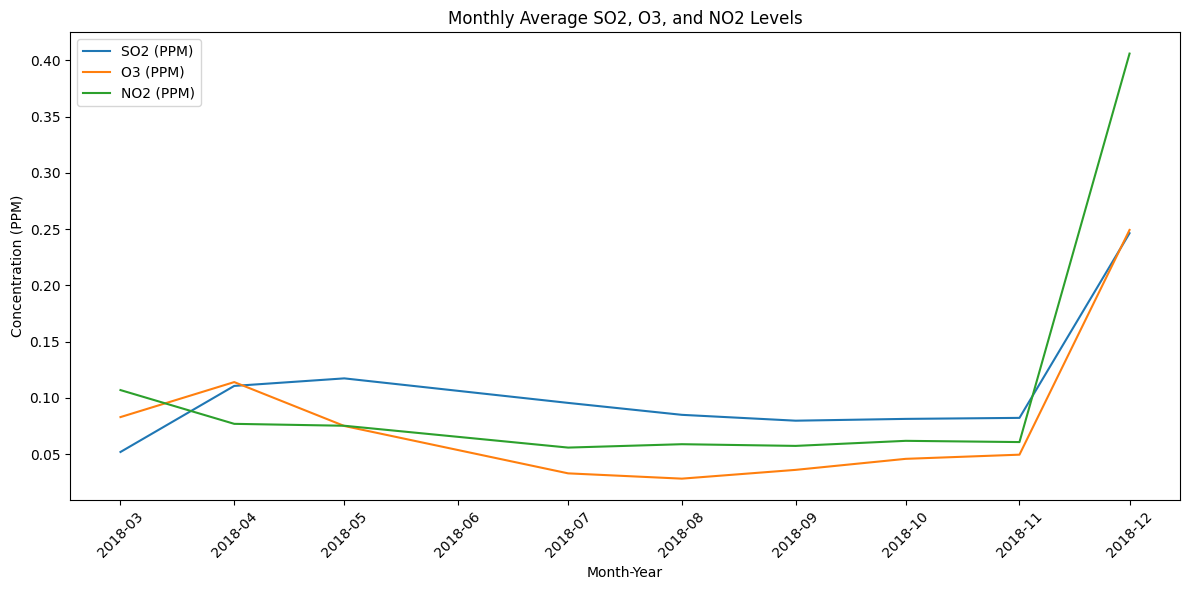

In [12]:
# Convert 'Month-Year' to datetime format for sorting
pollution_pd['Month-Year'] = pd.to_datetime(pollution_pd['Month-Year'], format='%y-%b')

# Group by month and calculate averages for numeric columns only
numeric_columns = ['SO2(PPM)', 'O3(PPM)', 'NO2(PPM)']
monthly_avg = pollution_pd.groupby('Month-Year')[numeric_columns].mean().reset_index()

# Plotting SO2, O3, NO2 trends
plt.figure(figsize=(12,6))

sns.lineplot(x='Month-Year', y='SO2(PPM)', data=monthly_avg, label='SO2 (PPM)')
sns.lineplot(x='Month-Year', y='O3(PPM)', data=monthly_avg, label='O3 (PPM)')
sns.lineplot(x='Month-Year', y='NO2(PPM)', data=monthly_avg, label='NO2 (PPM)')

plt.title("Monthly Average SO2, O3, and NO2 Levels")
plt.xlabel("Month-Year")
plt.ylabel("Concentration (PPM)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


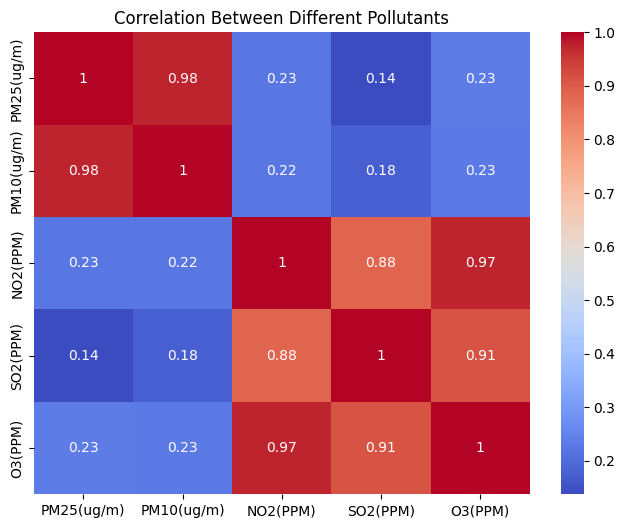

In [13]:
# Select relevant columns
pollutants = pollution_pd[[
    'PM25(ug/m)',
    'PM10(ug/m)',
    'NO2(PPM)',
    'SO2(PPM)',
    'O3(PPM)'
]]

# Compute correlation matrix
corr_matrix = pollutants.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Between Different Pollutants")
plt.show()


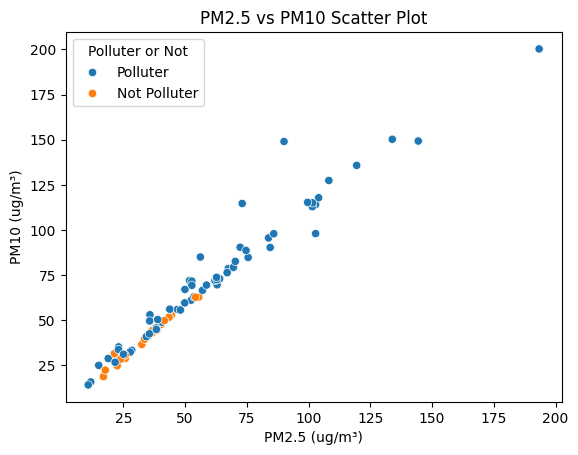

In [14]:
sns.scatterplot(x='PM25(ug/m)', y='PM10(ug/m)', hue='Polluter or Not', data=pollution_pd)
plt.title("PM2.5 vs PM10 Scatter Plot")
plt.xlabel("PM2.5 (ug/m³)")
plt.ylabel("PM10 (ug/m³)")
plt.show()


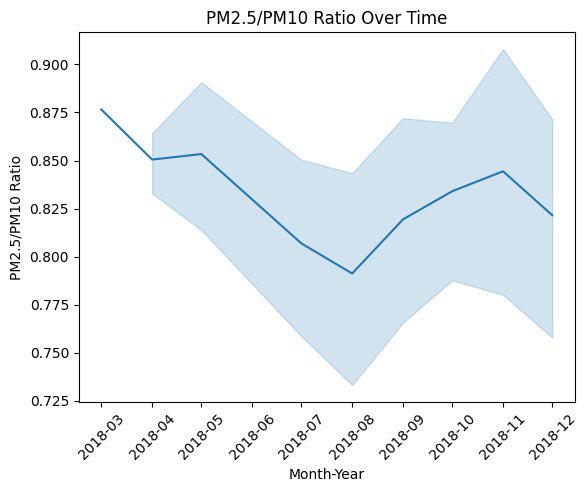

In [15]:

pollution_pd['PM2.5/PM10 Ratio'] = pollution_pd['PM25(ug/m)'] / pollution_pd['PM10(ug/m)']
sns.lineplot(x='Month-Year', y='PM2.5/PM10 Ratio', data=pollution_pd)
plt.title("PM2.5/PM10 Ratio Over Time")
plt.xticks(rotation=45)
plt.show()


# Loaction wise levels of PM 2.5 and PM 10

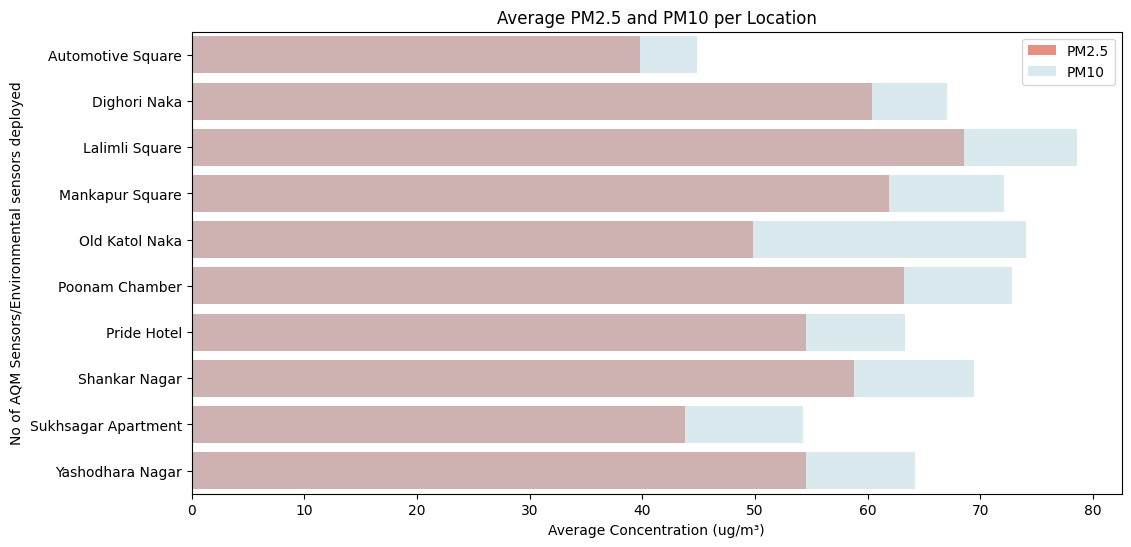

In [16]:
# Group by location and get average values
# Make sure numeric_columns contains all the necessary columns
numeric_columns = ['PM25(ug/m)', 'PM10(ug/m)', 'NO2(PPM)', 'SO2(PPM)', 'O3(PPM)']
location_avg = pollution_pd.groupby('No of AQM Sensors/Environmental sensors deployed')[numeric_columns].mean().reset_index()

# Barplot for PM2.5 and PM10
plt.figure(figsize=(12,6))
sns.barplot(x='PM25(ug/m)', y='No of AQM Sensors/Environmental sensors deployed', data=location_avg, color='salmon', label='PM2.5')
sns.barplot(x='PM10(ug/m)', y='No of AQM Sensors/Environmental sensors deployed', data=location_avg, color='lightblue', label='PM10', alpha=0.5)
plt.title("Average PM2.5 and PM10 per Location")
plt.xlabel("Average Concentration (ug/m³)")
plt.legend()
plt.show()

# Location wise Pollution count

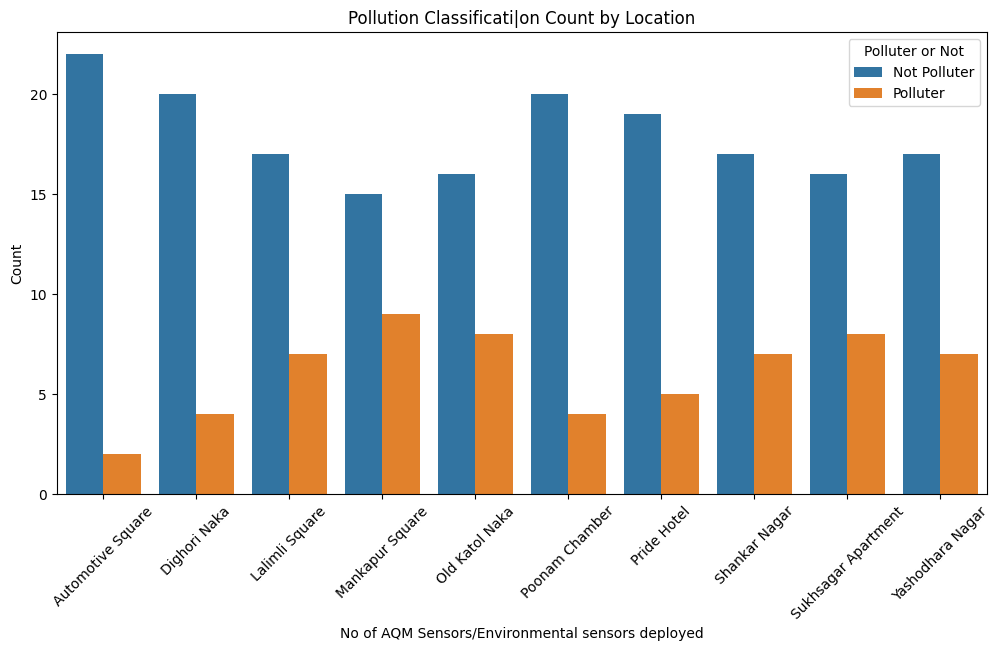

In [17]:
# Count of Polluter vs Not Polluter per location
location_pollution_count = pollution_pd.groupby(['No of AQM Sensors/Environmental sensors deployed', 'Polluter or Not']).size().reset_index(name='Count')

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x='No of AQM Sensors/Environmental sensors deployed', y='Count', hue='Polluter or Not', data=location_pollution_count) # Changed column name here
plt.title("Pollution Classificati|on Count by Location")
plt.xticks(rotation=45)
plt.show()


# Location wise average SO2, NO2,O3 concentrations

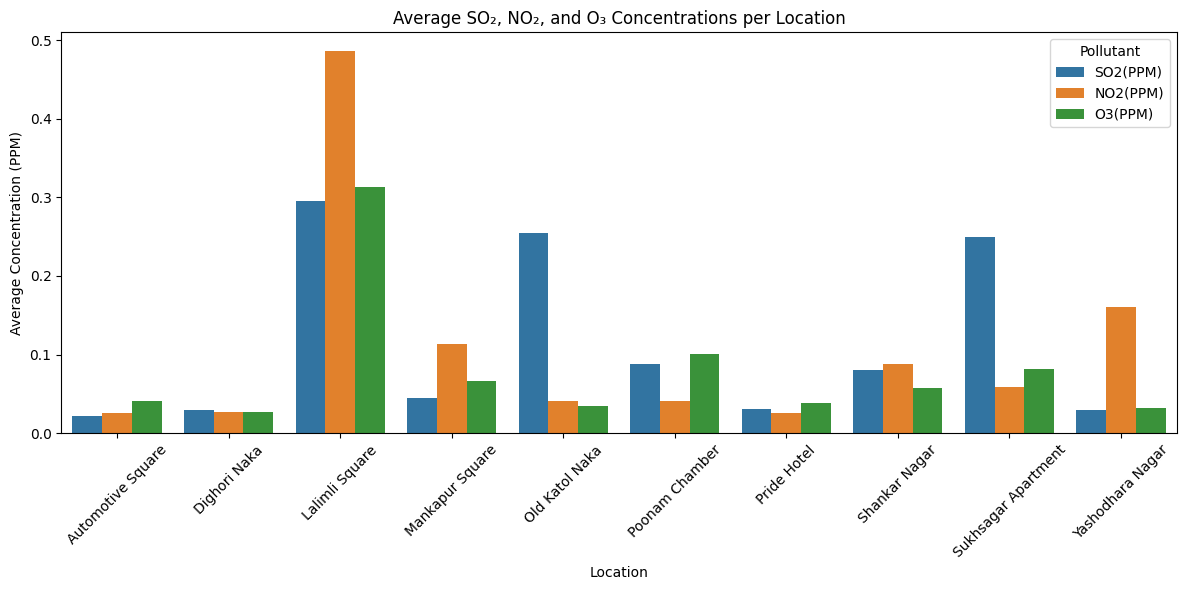

In [18]:
location_avg = pollution_pd.groupby('No of AQM Sensors/Environmental sensors deployed', as_index=False).agg({
    'PM25(ug/m)': 'mean',
    'PM10(ug/m)': 'mean',
    'NO2(PPM)': 'mean',
    'SO2(PPM)': 'mean',
    'O3(PPM)': 'mean'  # Include other numeric columns here
})
# Select pollutants to visualize
pollutants = ['SO2(PPM)', 'NO2(PPM)', 'O3(PPM)']

# Melt the dataframe to long format for seaborn
location_melted = pd.melt(location_avg,
                          id_vars='No of AQM Sensors/Environmental sensors deployed',
                          value_vars=pollutants,
                          var_name='Pollutant',
                          value_name='Concentration')

# Set figure size
plt.figure(figsize=(12, 6))

# Create a barplot
sns.barplot(x='No of AQM Sensors/Environmental sensors deployed',
            y='Concentration',
            hue='Pollutant',
            data=location_melted)

# Set titles and labels
plt.title("Average SO₂, NO₂, and O₃ Concentrations per Location")
plt.xlabel("Location")
plt.ylabel("Average Concentration (PPM)")
plt.xticks(rotation=45)
plt.legend(title="Pollutant")
plt.tight_layout()

# Show the plot
plt.show()

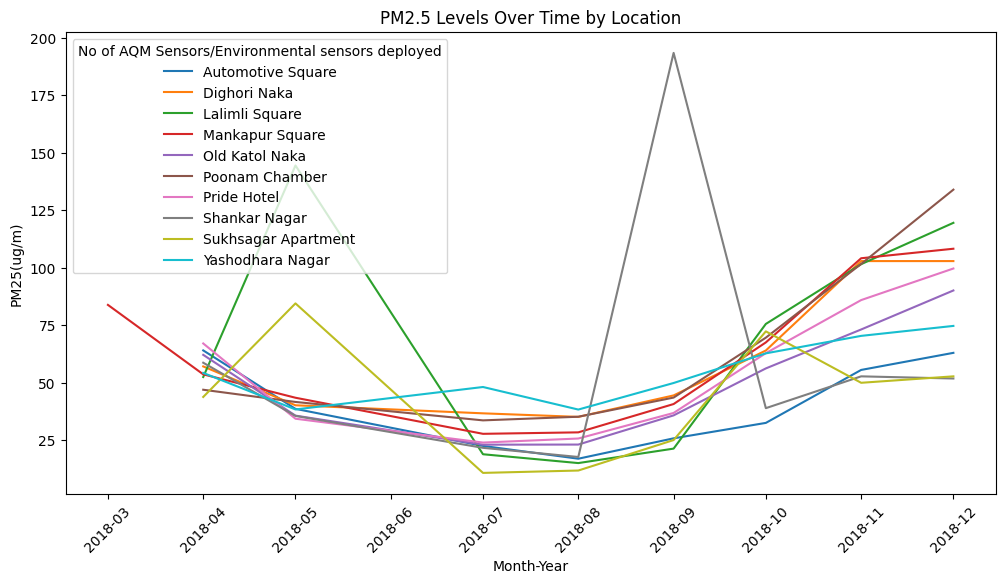

In [19]:
# Lineplot of PM2.5 over time per location
plt.figure(figsize=(12,6))
sns.lineplot(x='Month-Year', y='PM25(ug/m)', hue='No of AQM Sensors/Environmental sensors deployed', data=pollution_pd) # Changed hue column name
plt.title("PM2.5 Levels Over Time by Location")
plt.xticks(rotation=45)
plt.show()


# Almost similar graph will come for PM 10 as they are highly correlated




#Applying a Machine Learning Algorithm

Now we will apply machine learning algorithm to predict pollution or no pollution one month in advance

In [20]:
from pyspark.sql.functions import to_date, col # Import to_date function

# Convert Month-Year to Date format
df = df.withColumn("Date", to_date(col("Month-Year"), "yy-MMM"))


In [21]:
df.show()

+---------+----------+----------+----------+--------+--------+-------+------------------------------------------------+---------------+----------+
|City Name|Month-Year|PM25(ug/m)|PM10(ug/m)|NO2(PPM)|SO2(PPM)|O3(PPM)|No of AQM Sensors/Environmental sensors deployed|Polluter or Not|      Date|
+---------+----------+----------+----------+--------+--------+-------+------------------------------------------------+---------------+----------+
|   Nagpur|    18-Dec|     62.93|     69.61|   0.037|   0.012|  0.041|                               Automotive Square|       Polluter|2018-12-01|
|   Nagpur|    18-Nov|      55.5|     62.81|   0.023|   0.015|  0.037|                               Automotive Square|   Not Polluter|2018-11-01|
|   Nagpur|    18-Oct|     32.47|     36.53|   0.018|   0.021|  0.036|                               Automotive Square|   Not Polluter|2018-10-01|
|   Nagpur|    18-Sep|     25.76|     28.82|   0.016|    0.03|  0.029|                               Automotive Square

In [22]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

window_spec = Window.partitionBy("No of AQM Sensors/Environmental sensors deployed").orderBy("Date")

df = df.withColumn("PM2_5_last_month", lag("PM25(ug/m)").over(window_spec))\
       .withColumn("PM10_last_month", lag("PM10(ug/m)").over(window_spec))\
       .withColumn("NO2_last_month", lag("NO2(PPM)").over(window_spec))\
       .withColumn("SO2_last_month", lag("SO2(PPM)").over(window_spec))\
       .withColumn("O3_last_month", lag("O3(PPM)").over(window_spec))\
       .withColumn("location", col("No of AQM Sensors/Environmental sensors deployed"))

df = df.dropna(subset=["PM2_5_last_month", "PM10_last_month", "NO2_last_month", "SO2_last_month", "O3_last_month"])


In [23]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Convert location to numeric
location_indexer = StringIndexer(inputCol="location", outputCol="location_index")

# Define features
feature_cols = [
    "PM2_5_last_month",
    "PM10_last_month",
    "NO2_last_month",
    "SO2_last_month",
    "O3_last_month",
    "location_index"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")


In [24]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.sql.functions import when # Import the when function

rf = RandomForestClassifier(featuresCol="features", labelCol="label")

df = df.withColumn("label", when(col("Polluter or Not") == "Polluter", 1).otherwise(0))
pipeline = Pipeline(stages=[location_indexer, assembler, rf])

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data)

In [25]:
predictions = model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from sklearn.metrics import confusion_matrix, classification_report


evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)




In [26]:
print(f" Accuracy: {accuracy:.4f}")

 Accuracy: 0.6875


In [27]:
# Convert Spark DataFrame to Pandas and extract the column values as arrays
y_true = predictions.select("label").toPandas()['label'].values
y_pred = predictions.select("prediction").toPandas()['prediction'].values

# Get unique classes in y_true
unique_classes = set(y_true)

# Adjust target_names based on unique classes
if len(unique_classes) == 1:
    if 1 in unique_classes:
        target_names = ["Polluter"]
    else:
        target_names = ["Not Polluter"]
else:
    target_names = ["Not Polluter", "Polluter"]  # Original target names

# Compute metrics using sklearn
print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names)) # Pass adjusted target_names

# Confusion Matrix
print(" Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


 Classification Report:

              precision    recall  f1-score   support

Not Polluter       0.60      0.50      0.55         6
    Polluter       0.73      0.80      0.76        10

    accuracy                           0.69        16
   macro avg       0.66      0.65      0.65        16
weighted avg       0.68      0.69      0.68        16

 Confusion Matrix:
[[3 3]
 [2 8]]


In [28]:
# Collect user input from the notebook
pm25 = float(input("Enter previous month's PM2.5 (µg/m³): "))
pm10 = float(input("Enter previous month's PM10 (µg/m³): "))
no2 = float(input("Enter previous month's NO2 (ppm): "))
so2 = float(input("Enter previous month's SO2 (ppm): "))
o3 = float(input("Enter previous month's O3 (ppm): "))
location = input("Enter location (e.g., Automotive Square): ")


# Create a Spark DataFrame with matching column names
manual_input_df = spark.createDataFrame([
    (pm25, pm10, no2, so2, o3, location)
], ["PM2_5_last_month", "PM10_last_month", "NO2_last_month", "SO2_last_month", "O3_last_month", "location"])


# Run prediction using the trained pipeline model
prediction = model.transform(manual_input_df)

# Show numeric and label output
prediction = prediction.withColumn("Predicted_Label",
                                   when(col("prediction") == 1, "Polluter").otherwise("Not Polluter"))

prediction.select("prediction", "Predicted_Label").show()



Enter previous month's PM2.5 (µg/m³): 9
Enter previous month's PM10 (µg/m³): 0.08
Enter previous month's NO2 (ppm): 0.07
Enter previous month's SO2 (ppm): 0.05
Enter previous month's O3 (ppm): 0.06
Enter location (e.g., Automotive Square): Automotive Square
+----------+---------------+
|prediction|Predicted_Label|
+----------+---------------+
|       0.0|   Not Polluter|
+----------+---------------+

